In [1]:
import sys
sys.path.append("../")
sys.path.append("../../")
import os
from detectron2.data import DatasetCatalog, MetadataCatalog
from detectron2.engine import default_argument_parser
from launch_utils import setup
from pgrcnn.utils.custom_visualizer import JerseyNumberVisualizer
import random, cv2
import matplotlib.pyplot as plt
import torch
import kornia
import numpy as np
# for t-sne
from matplotlib.ticker import NullFormatter
from sklearn import manifold, datasets
from time import time

%matplotlib inline

args = default_argument_parser().parse_args(args=[])
# lazy add config file
args.config_file = "../../configs/faster_rcnn_R_50_FPN_1x.yaml"
cfg = setup(args)

dataset_root = os.path.join('../../../../', 'datasets/jnw') # working dir is the current file
dataset_dir = os.path.join(dataset_root, 'total/')
annotation_dir = os.path.join(dataset_root, 'annotations/processed_annotations.json')
# register_jerseynumbers()
# dataset_dicts = get_dicts("jerseynumbers", annotation_dir, split=[0,1,2,3])
# register_jerseynumbers()
dataset_dicts = DatasetCatalog.get("jerseynumbers_train")
jnw_metadata = MetadataCatalog.get("jerseynumbers_train")


[04/15 11:43:02 detectron2]: Rank of current process: 0. World size: 1
[04/15 11:43:02 detectron2]: Environment info:
------------------------  ------------------------------------------------------------------------------
sys.platform              darwin
Python                    3.8.1 (default, Jan  8 2020, 16:15:59) [Clang 4.0.1 (tags/RELEASE_401/final)]
numpy                     1.18.1
detectron2                0.1.1 @/Users/henry/Research/da-det/detectron2
detectron2 compiler       clang 11.0.0
detectron2 CUDA compiler  not available
DETECTRON2_ENV_MODULE     <not set>
PyTorch                   1.4.0 @/Users/henry/anaconda3/envs/dev/lib/python3.8/site-packages/torch
PyTorch debug build       False
CUDA available            False
Pillow                    7.0.0
torchvision               0.5.0 @/Users/henry/anaconda3/envs/dev/lib/python3.8/site-packages/torchvision
cv2                       4.2.0
------------------------  -------------------------------------------------------------

[04/15 11:43:02 detectron2]: Full config saved to ./output/config.yaml
[04/15 11:43:02 d2.utils.env]: Using a generated random seed 2576842


file name:  /Users/henry/Research/da-det/datasets/jnw/total/15165_frame_388_0.png
{'image_id': 1305, 'file_name': '/Users/henry/Research/da-det/datasets/jnw/total/15165_frame_388_0.png', 'width': 117, 'height': 265, 'video_id': 1, 'annotations': [{'digit_bboxes': [[40, 72, 54, 99], [52, 72, 65, 97]], 'digit_labels': [3, 2], 'keypoints': [24, 75, 2, 58, 66, 2, 58, 131, 2, 43, 136, 2], 'person_bbox': [10, 29, 75, 238], 'bbox_mode': <BoxMode.XYXY_ABS: 0>, 'digit_ids': [3, 2]}]}


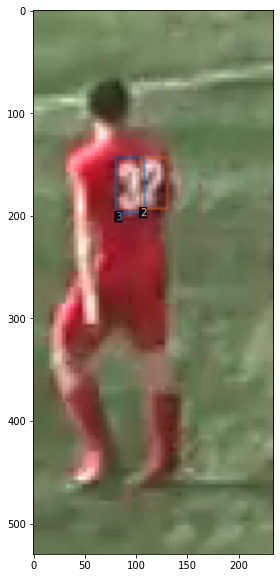

In [2]:
# dataset test
VIS_DATASET = True
NUM_IMAGE_SHOW = 1
if VIS_DATASET:
    for d in random.sample(dataset_dicts, NUM_IMAGE_SHOW):
        print("file name: ", os.path.abspath(d['file_name']))
        print(d)
        img = cv2.imread(d["file_name"])
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        visualizer = JerseyNumberVisualizer(img, metadata=jnw_metadata, scale=2)
        vis = visualizer.draw_dataset_dict(d)
        plt.figure(figsize = (20,10))
        
        plt.imshow(vis.get_image())
        plt.show()

In [2]:
def get_perspective_mat(dataset_dicts):
    mats = []
    for dataset_dict in dataset_dicts:
#         print(dataset_dict)
        for instance in dataset_dict['annotations']:
            # if both keypoints and digit bboxes exist
            if len(instance['keypoints']) > 0 and len(instance['digit_bboxes']) > 0:
                num_digit_bboxes = len(instance['digit_bboxes'])
                # keypoints 
                points_src = torch.tensor([[[instance['keypoints'][3*i], instance['keypoints'][3*i+1]] \
                    for i in range(len(instance['keypoints']) // 3)]], dtype=torch.float).repeat(num_digit_bboxes,1,1)
                # digit bbox four corners
                points_dst = torch.tensor([[[digit_bbox[0], digit_bbox[1]], [digit_bbox[2], digit_bbox[1]], \
                                            [digit_bbox[2], digit_bbox[3]], [digit_bbox[0], digit_bbox[3]], \
                                    ] for digit_bbox in instance['digit_bboxes']], dtype=torch.float)
                # compute perspective transform
                M: torch.tensor = kornia.get_perspective_transform(points_src, points_dst)
#                 print(M.size())
                mats.append(M)
            
#         break
    return mats
        
mats = get_perspective_mat(dataset_dicts)
mats = torch.cat(mats) # torch.Size([6160, 3, 3])
mats = mats.view(-1, 9).numpy()
print(mats.shape)

(6160, 9)


perplexity=5 in 62 sec
perplexity=30 in 72 sec
perplexity=50 in 95 sec
perplexity=100 in 1.5e+02 sec


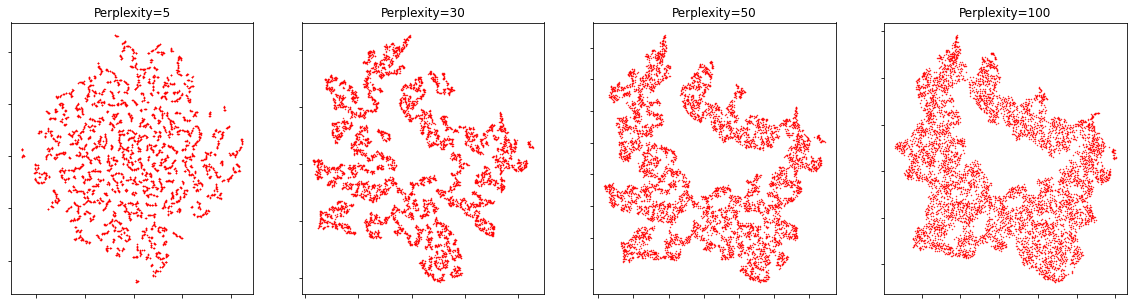

In [11]:
# t-sne
n_samples = 300
n_components = 2
(fig, subplots) = plt.subplots(1, 4, figsize=(20, 5))
perplexities = [5, 30, 50, 100]

for i, perplexity in enumerate(perplexities):
    ax = subplots[i]

    t0 = time()
    tsne = manifold.TSNE(n_components=n_components, init='random',
                         random_state=0, perplexity=perplexity, n_iter=5000)
    Y = tsne.fit_transform(mats)
    t1 = time()
    print("perplexity=%d in %.2g sec" % (perplexity, t1 - t0))
    ax.set_title("Perplexity=%d" % perplexity)
    ax.scatter(Y[:, 0], Y[:, 1], c="r", s=0.2)
#     ax.scatter(Y[green, 0], Y[green, 1], c="g")
    ax.xaxis.set_major_formatter(NullFormatter())
    ax.yaxis.set_major_formatter(NullFormatter())
    ax.axis('tight')
#     break

In [ ]:
# k-means
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
# #############################################################################
# Visualize the results on PCA-reduced data

reduced_data = PCA(n_components=2).fit_transform(mats)
kmeans = KMeans(init='k-means++', n_clusters=5, n_init=1)
kmeans.fit(reduced_data)

# Step size of the mesh. Decrease to increase the quality of the VQ.
h = .02     # point in the mesh [x_min, x_max]x[y_min, y_max].

# Plot the decision boundary. For that, we will assign a color to each
x_min, x_max = reduced_data[:, 0].min() - 1, reduced_data[:, 0].max() + 1
y_min, y_max = reduced_data[:, 1].min() - 1, reduced_data[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

# Obtain labels for each point in mesh. Use last trained model.
Z = kmeans.predict(np.c_[xx.ravel(), yy.ravel()])

# Put the result into a color plot
Z = Z.reshape(xx.shape)
plt.figure(1)
plt.clf()
plt.imshow(Z, interpolation='nearest',
           extent=(xx.min(), xx.max(), yy.min(), yy.max()),
           cmap=plt.cm.Paired,
           aspect='auto', origin='lower')

plt.plot(reduced_data[:, 0], reduced_data[:, 1], 'k.', markersize=2)
# Plot the centroids as a white X
centroids = kmeans.cluster_centers_
plt.scatter(centroids[:, 0], centroids[:, 1],
            marker='x', s=169, linewidths=3,
            color='w', zorder=10)
plt.title('K-means clustering on the digits dataset (PCA-reduced data)\n'
          'Centroids are marked with white cross')
plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)
plt.xticks(())
plt.yticks(())
plt.show()

ValueError: manhattan was provided as affinity. Ward can only work with euclidean distances.

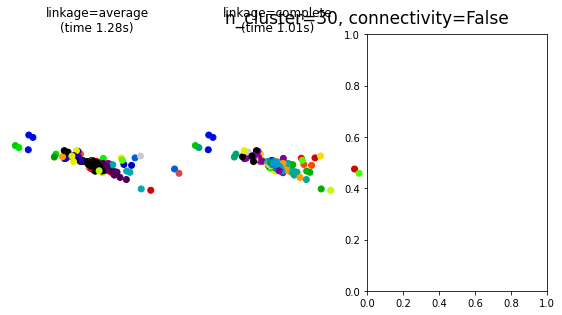

In [49]:
# Agglomerative clustering
import time
from sklearn.cluster import AgglomerativeClustering
from sklearn.neighbors import kneighbors_graph

# Generate sample data
n_samples = 1500
np.random.seed(0)
t = 1.5 * np.pi * (1 + 3 * np.random.rand(1, n_samples))
x = t * np.cos(t)
y = t * np.sin(t)


X = np.concatenate((x, y))
X += .7 * np.random.randn(2, n_samples)
X = X.T

# print(X.shape)

# Create a graph capturing local connectivity. Larger number of neighbors
# will give more homogeneous clusters to the cost of computation
# time. A very large number of neighbors gives more evenly distributed
# cluster sizes, but may not impose the local manifold structure of
# the data
# knn_graph = kneighbors_graph(mats, 500, include_self=False)

for connectivity in (None,):
    for n_clusters in (30, 3):
        plt.figure(figsize=(10, 4))
        for index, linkage in enumerate(('average',
                                         'complete',
                                         'ward',
                                         'single')):
            plt.subplot(1, 4, index + 1)
            model = AgglomerativeClustering(linkage=linkage,
                                            connectivity=connectivity,
                                            n_clusters=n_clusters, affinity='manhattan')
            t0 = time.time()
            model.fit(mats)
            elapsed_time = time.time() - t0
            plt.scatter(mats[:, 0], mats[:, 1], c=model.labels_,
                        cmap=plt.cm.nipy_spectral)
            plt.title('linkage=%s\n(time %.2fs)' % (linkage, elapsed_time),
                      fontdict=dict(verticalalignment='top'))
            plt.axis('equal')
            plt.axis('off')

            plt.subplots_adjust(bottom=0, top=.89, wspace=0,
                                left=0, right=1)
            plt.suptitle('n_cluster=%i, connectivity=%r' %
                         (n_clusters, connectivity is not None), size=17)


plt.show()

(6160, 9)
Estimated number of clusters: 2
Estimated number of noise points: 31
Silhouette Coefficient: 0.831


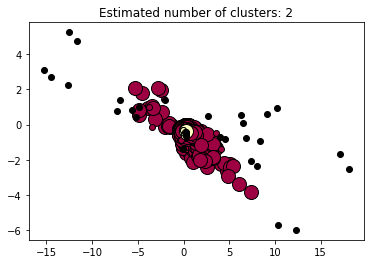

In [37]:
# DBSCAN

from sklearn.cluster import DBSCAN
from sklearn import metrics
from sklearn.datasets import make_blobs
from sklearn.preprocessing import StandardScaler


# #############################################################################
# Compute DBSCAN
print(mats.shape)
db = DBSCAN(eps=50, min_samples=10).fit(mats)
core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True
labels = db.labels_

# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)

print('Estimated number of clusters: %d' % n_clusters_)
print('Estimated number of noise points: %d' % n_noise_)
print("Silhouette Coefficient: %0.3f"
      % metrics.silhouette_score(mats, labels))

# #############################################################################
# Plot result

# Black removed and is used for noise instead.
unique_labels = set(labels)
colors = [plt.cm.Spectral(each)
          for each in np.linspace(0, 1, len(unique_labels))]
for k, col in zip(unique_labels, colors):
    if k == -1:
        # Black used for noise.
        col = [0, 0, 0, 1]

    class_member_mask = (labels == k)

    xy = mats[class_member_mask & core_samples_mask]
    plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
             markeredgecolor='k', markersize=14)

    xy = mats[class_member_mask & ~core_samples_mask]
    plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
             markeredgecolor='k', markersize=6)

plt.title('Estimated number of clusters: %d' % n_clusters_)
plt.show()

Estimated number of clusters: 417
Silhouette Coefficient: 0.492


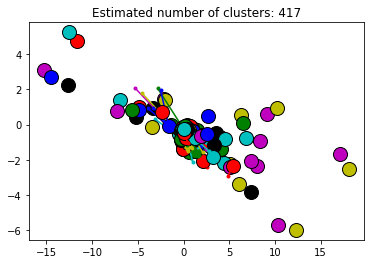

In [46]:
from sklearn.cluster import AffinityPropagation
from sklearn import metrics
from sklearn.datasets import make_blobs


# #############################################################################
# Compute Affinity Propagation
af = AffinityPropagation(preference=-90).fit(mats)
cluster_centers_indices = af.cluster_centers_indices_
labels = af.labels_

n_clusters_ = len(cluster_centers_indices)

print('Estimated number of clusters: %d' % n_clusters_)
print("Silhouette Coefficient: %0.3f"
      % metrics.silhouette_score(mats, labels, metric='sqeuclidean'))

# #############################################################################
# Plot result
import matplotlib.pyplot as plt
from itertools import cycle

plt.close('all')
plt.figure(1)
plt.clf()

colors = cycle('bgrcmykbgrcmykbgrcmykbgrcmyk')
for k, col in zip(range(n_clusters_), colors):
    class_members = labels == k
    cluster_center = mats[cluster_centers_indices[k]]
    plt.plot(mats[class_members, 0], mats[class_members, 1], col + '.')
    plt.plot(cluster_center[0], cluster_center[1], 'o', markerfacecolor=col,
             markeredgecolor='k', markersize=14)
    for x in mats[class_members]:
        plt.plot([cluster_center[0], x[0]], [cluster_center[1], x[1]], col)

plt.title('Estimated number of clusters: %d' % n_clusters_)
plt.show()

tensor([[[ 24.,  75.],
         [ 58.,  66.],
         [ 58., 131.],
         [ 43., 136.]],

        [[ 24.,  75.],
         [ 58.,  66.],
         [ 58., 131.],
         [ 43., 136.]]]) tensor([[[40., 72.],
         [54., 72.],
         [54., 99.],
         [40., 99.]],

        [[52., 72.],
         [65., 72.],
         [65., 97.],
         [52., 97.]]])
tensor([[[ 1.4205e-01, -2.6119e-01,  3.9861e+01],
         [-1.0736e-01, -2.4145e-01,  6.3311e+01],
         [-1.8838e-03, -4.8368e-03,  1.0000e+00]],

        [[ 1.0392e-01, -3.1439e-01,  5.1871e+01],
         [-1.0945e-01, -2.4936e-01,  6.3955e+01],
         [-1.8838e-03, -4.8368e-03,  1.0000e+00]]])
tensor([[[40.0000, 72.0000],
         [54.0000, 72.0000],
         [54.0000, 99.0000],
         [40.0000, 99.0000]],

        [[52.0000, 72.0000],
         [65.0000, 72.0000],
         [65.0000, 97.0000],
         [52.0000, 97.0000]]])


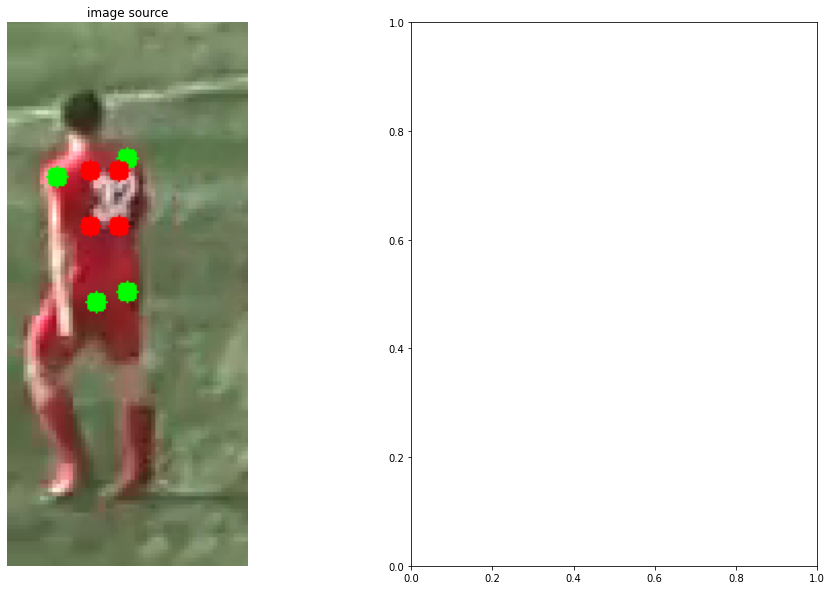

In [3]:
"""

Warp image using perspective transform
======================================

"""


def get_perspective_mat(dataset_dicts):
    

# read the image with OpenCV
# print(os.path.abspath('../../datasets/jnw/total/4770_2.png'))
# img: np.ndarray = cv2.imread('../../../../datasets/jnw/total/new_3285_1.png')

# convert to torch tensor
data: torch.tensor = kornia.image_to_tensor(img, keepdim=False)  # BxCxHxW

# the source points are the region to crop corners
# points_src = torch.tensor([[
#     [82., 60.], [139., 59.], [132., 121.], [101., 121.],
# ]])

single_instance = d['annotations'][0]
points_src = torch.tensor([[[single_instance['keypoints'][3*i], single_instance['keypoints'][3*i+1]] \
for i in range(len(single_instance['keypoints']) // 3)]], dtype=torch.float).repeat(2,1,1)

# the destination points are the image vertexes
h, w = 64, 64  # destination size
# points_dst = torch.tensor([[
#     [w, 0.], [2*w - 1., 0.], [3*w/4 - 1., h - 1.], [w/4., h - 1.],
# ]])
# x1, y1, x2, y2 = single_instance['digit_bboxes'][0]
points_dst = torch.tensor([[
    [digit_bbox[0], digit_bbox[1]], [digit_bbox[2], digit_bbox[1]], [digit_bbox[2], digit_bbox[3]], [digit_bbox[0], digit_bbox[3]],
] for digit_bbox in single_instance['digit_bboxes']], dtype=torch.float)

print(points_src, points_dst)

# compute perspective transform
M: torch.tensor = kornia.get_perspective_transform(points_src, points_dst)

print(M)
points_dst_pred = kornia.transform_points(M, points_src)
print(points_dst_pred)
# equivalent
# points_dst_pred = torch.matmul(M, kornia.convert_points_to_homogeneous(points_src).permute(0,2,1))
# print(kornia.convert_points_from_homogeneous(points_dst_pred.permute(0,2,1)))

# warp the original image by the found transform
# data_warp: torch.tensor = kornia.warp_perspective(data.float(), M, dsize=(h, w))

# convert back to numpy
# img_warp: np.ndarray = kornia.tensor_to_image(data_warp.byte())

# draw points into original image
for i in range(4):
    center = tuple(points_src[0, i].long().numpy())
    img = cv2.circle(img.copy(), center, 5, (0, 255, 0), -1)
    center = tuple(points_dst[0, i].long().numpy())
    img = cv2.circle(img.copy(), center, 5, (255, 0, 0), -1)

# create the plot
fig, axs = plt.subplots(1, 2, figsize=(16, 10))
axs = axs.ravel()

axs[0].axis('off')
axs[0].set_title('image source')
axs[0].imshow(img)

# axs[1].axis('off')
# axs[1].set_title('image destination')
# axs[1].imshow(img_warp)